# Ray-tracing with regular pyramids

This example shows how to define a structure, and the form of the calculation outputs, for a silicon wafer with pyramid texturing on the front surface and a planar rear surface, and compares the results with those of a well-known wafer ray-tracer (PVLighthouse). The absorption profile is also calculated automatically.

In [1]:
import numpy as np

from rayflare.ray_tracing.rt import rt_structure
from rayflare.textures import regular_pyramids, planar_surface
from rayflare.options import default_options

from solcore import material
from solcore import si

# imports for plotting
import matplotlib.pyplot as plt
import seaborn as sns

We define the relevant materials. In this case, we are going to compare the results at the end with ray-tracing results from PVLighthouse's wafer ray tracer, so we want to make sure we are using exactly the same optical constant data. For this, we will use Solcore's ability to download and pull materials from the refractiveindex.info database. First we download the database (if you've already done this previously you will be prompted to ask if you would like to re-download it) and then we search it for the Green 2008 silicon optical constant data. We then define a Solcore material by referencing this search result (for this version of the database, it is the entry with page id 566). We then set some options: the number of rays to trace at each wavelengths, how many x/y points to scan across, the wavelengths, and that the computation should be done in parallel (by default this will use all the available cores).

In [2]:
# setting up some colours for plotting
pal = sns.color_palette("husl", 4)


# setting up Solcore materials
Air = material('Air')()

from solcore.absorption_calculator import download_db, search_db
# download_db()
Si_Green2008 = search_db('Green-2008')[0][0]
Si = material(str(Si_Green2008), nk_db=True)()

# number of x and y points to scan across
nxy = 10

# setting options
options = default_options()
options.wavelengths = np.linspace(300, 1201, 100) * 1e-9
options.nx = nxy
options.ny = nxy
options.n_rays = 2 * nxy ** 2
options.depth_spacing = si('0.1um')
options.parallel = True

Database file found at /home/phoebe/.solcore/nk/nk.db
1 results found.
pageid	shelf	book	page	filepath	hasrefractive	hasextinction	rangeMin	rangeMax	points
566	main	Si	Green-2008	main/Si/Green-2008.yml	1	1	0.25	1.45	121


Define the structure: the front is made of inverted regular triangles (upright=False) with an opening angle of 55 degrees and a size of 2 microns. The back surface is planar. The rt_structure class takes a list of textures and a list of materials; there must always be one more entry in the list of textures than the number of materials (the incidence and transmission media are specified separately). We then calculate the reflection, transmission, and absorption per layer. The absorption profile will also be calculated because for ray-tracing this requires essentially no additional work, since it only uses Beer-Lambert like absorption.

In [3]:
flat_surf = planar_surface(size=2) # pyramid size in microns
triangle_surf = regular_pyramids(55, upright=False, size=2)

# set up ray-tracing options
rtstr = rt_structure(textures=[triangle_surf, flat_surf],
                    materials = [Si],
                    widths=[si('300um')], incidence=Air, transmission=Air)

result = rtstr.calculate(options)

Database file found at /home/phoebe/.solcore/nk/nk.db
Material main/Si/Green-2008.yml loaded.
Database file found at /home/phoebe/.solcore/nk/nk.db
Material main/Si/Green-2008.yml loaded.


Plot results, and compare them with PVLighthouse ray-tracing results for the same structure.

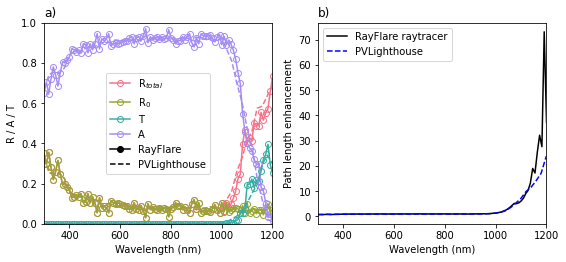

In [4]:
PVlighthouse = np.loadtxt('RAT_data_300um_2um_55.csv', delimiter=',', skiprows=1)

fig=plt.figure(figsize=(9,3.7))
plt.subplot(1,2,1)
plt.plot(options['wavelengths']*1e9, result['R'], '-o',
         color=pal[0], label=r'R$_{total}$', fillstyle='none')
plt.plot(options['wavelengths']*1e9, result['R0'], '-o',
         color=pal[1], label=r'R$_0$', fillstyle='none')
plt.plot(options['wavelengths']*1e9, result['T'], '-o',
         color=pal[2], label=r'T', fillstyle='none')
plt.plot(options['wavelengths']*1e9, result['A_per_layer'][:,0], '-o',
         color=pal[3], label=r'A', fillstyle='none')
plt.plot(PVlighthouse[:, 0], PVlighthouse[:, 2], '--', color=pal[0])
plt.plot(PVlighthouse[:, 0], PVlighthouse[:, 9], '--', color=pal[2])
plt.plot(PVlighthouse[:, 0], PVlighthouse[:, 3], '--', color=pal[1])
plt.plot(PVlighthouse[:, 0], PVlighthouse[:, 5], '--', color=pal[3])
plt.title('a)', loc='left')
plt.plot(-1, -1, '-ok', label='RayFlare')
plt.plot(-1, -1, '--k', label='PVLighthouse')
plt.xlabel('Wavelength (nm)')
plt.ylabel('R / A / T')
plt.ylim(0, 1)
plt.xlim(300, 1200)

plt.legend()

A_single_pass = 1 - np.exp(-200e-6 * Si.alpha(options['wavelengths']))
A_single_pass_PVL = 1 - np.exp(-200e-6 * Si.alpha(PVlighthouse[:, 0] / 1e9))
lambertian = 4*Si.n(options['wavelengths'])**2

plt.subplot(1,2,2)
plt.plot(options['wavelengths']*1e9, result['A_per_layer'][:,0] / A_single_pass,
         '-k',  label='RayFlare raytracer')
plt.plot(PVlighthouse[:, 0], PVlighthouse[:, 5] / A_single_pass_PVL,
         '--b', label='PVLighthouse')
plt.legend(loc='upper left')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Path length enhancement')
plt.xlim(300, 1200)
plt.title('b)', loc='left')
plt.show()

Plotting the absorption profile at wavelengths bigger than about 1000 nm:

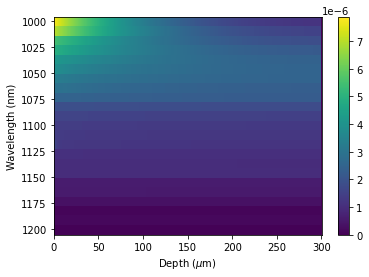

In [5]:
min_wl = 1000
ind = np.argmin(np.abs(options.wavelengths*1e9 -  min_wl))

z_pos = np.arange(0, 300, options.depth_spacing*1e6)

plt.figure()
pcm = plt.pcolormesh(z_pos, options.wavelengths[ind:]*1e9, result['profile'][ind:,:],
                     shading='auto')
plt.colorbar(pcm)
plt.gca().invert_yaxis()
plt.xlabel(r'Depth ($\mu$m)')
plt.ylabel('Wavelength (nm)')
plt.show()